In [134]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier LiAbraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [3]:
with open('netsparker.txt', 'r') as file:
    netsparker  = file.readlines()
    
with open('w3af.txt', 'r') as file:
    w3af = file.readlines()
    
with open('acunetix.txt', 'r') as file:
    acunetix  = file.readlines()

In [4]:
sqli_list = ['select','instert','update','delete','alter',
             'update','--','#','exec','hex','utf-8',"\'"]

xss_list=['script','onload','onerror','img','body','iframe', 
          'input','link','table','div','object','form']

xss_sqli_patterns= xss_list+sqli_list

### Creating a csv data 

#### Dataframe for netsparker

In [5]:
netsparker_df = pd.DataFrame([[x.strip('"') for x in y.split()] for y in netsparker])
netsparker_df.replace([None,'-'],np.nan, inplace=True)
netsparker_df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:05,+0300],GET,/DVWA/,HTTP/1.1,200,2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/,HTTP/1.1,200,263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
for x in netsparker_df.columns:
    netsparker_df['ip_address']=netsparker_df[0]
    netsparker_df['remote_log_name']=netsparker_df[1]
    netsparker_df['authenticated_user_name']=netsparker_df[2]
    netsparker_df['timestamp']=netsparker_df[3]+' '+netsparker_df[4]
    netsparker_df['method']=netsparker_df[5]
    netsparker_df['requesta_url']=netsparker_df[6]
    netsparker_df['protocol']=netsparker_df[7]
    netsparker_df['status_code']=netsparker_df[8]
    netsparker_df['bytes_transferred']=netsparker_df[9]
    netsparker_df['referrer_url']=netsparker_df[10]
    netsparker_df['user_agent']=netsparker_df[11]+' '+netsparker_df[12]+' '+netsparker_df[13]+' '+\
    netsparker_df[14]+' '+netsparker_df[15]+' '+netsparker_df[16]+' '+netsparker_df[17]+' '+netsparker_df[17]\
    +" "+netsparker_df[18]+' '+netsparker_df[19]+" "+netsparker_df[20]+" "+netsparker_df[21]
netsparker_df.head()

,0,1,2,3,4,5,6,7,8,9,...,remote_log_name,authenticated_user_name,timestamp,method,requesta_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:05,+0300],GET,/DVWA/,HTTP/1.1,200,2020,...,NaN,NaN,[22/Dec/2016:15:19:05 +0300],GET,/DVWA/,HTTP/1.1,200,2020,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
1,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/,HTTP/1.1,200,263,...,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/,HTTP/1.1,200,263,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,...,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
3,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,...,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
4,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,...,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...


In [7]:
len(netsparker_df[netsparker_df.user_agent.isnull()].index)

48

In [8]:
netsparker_df[[11,12,13,14,15,16,17,18,19,20,21]][netsparker_df.user_agent.isnull()].head()

,11,12,13,14,15,16,17,18,19,20,21
1724,{,:;};,echo,"\""NS:\",$(/bin/sh,-c,"\""expr",268409241,NaN,"2\"")",Mozilla/5.0
1850,{,:;};,echo,"\""NS:\",$(/bin/sh,-c,"\""expr",268409241,NaN,"2\"")",Mozilla/5.0
1971,{,:;};,echo,"\""NS:\",$(/bin/sh,-c,"\""expr",268409241,NaN,"2\"")",Mozilla/5.0
2156,{,:;};,echo,"\""NS:\",$(/bin/sh,-c,"\""expr",268409241,NaN,"2\"")",Mozilla/5.0
2164,{,:;};,echo,"\""NS:\",$(/bin/sh,-c,"\""expr",268409241,NaN,"2\"")",Mozilla/5.0


In [9]:
netsparker_df[[21,22,23,24,25,26,27,28,29,30,31]][netsparker_df.user_agent.isnull()].head()

,21,22,23,24,25,26,27,28,29,30,31
1724,Mozilla/5.0,(Windows,NT,6.3;,WOW64),AppleWebKit/537.36,"(KHTML,",like,Gecko),Chrome/41.0.2272.16,Safari/537.36
1850,Mozilla/5.0,(Windows,NT,6.3;,WOW64),AppleWebKit/537.36,"(KHTML,",like,Gecko),Chrome/41.0.2272.16,Safari/537.36
1971,Mozilla/5.0,(Windows,NT,6.3;,WOW64),AppleWebKit/537.36,"(KHTML,",like,Gecko),Chrome/41.0.2272.16,Safari/537.36
2156,Mozilla/5.0,(Windows,NT,6.3;,WOW64),AppleWebKit/537.36,"(KHTML,",like,Gecko),Chrome/41.0.2272.16,Safari/537.36
2164,Mozilla/5.0,(Windows,NT,6.3;,WOW64),AppleWebKit/537.36,"(KHTML,",like,Gecko),Chrome/41.0.2272.16,Safari/537.36


In [10]:
for x in netsparker_df[netsparker_df.user_agent.isnull()].index:
        netsparker_df.loc[x,'user_agent']=netsparker_df.loc[x,21]+" "+netsparker_df.loc[x,22]+\
        " "+netsparker_df.loc[x,23]+" "+netsparker_df.loc[x,24]+" "+netsparker_df.loc[x,25]+' '+\
        netsparker_df.loc[x,26]+' '+netsparker_df.loc[x,27]+' '+netsparker_df.loc[x,28]+' '+\
        netsparker_df.loc[x,29]+' '+netsparker_df.loc[x,30]+" "+netsparker_df.loc[x,31]

In [11]:
len(netsparker_df[netsparker_df.user_agent.isnull()].index)

0

In [12]:
netsparker_df.head()

,0,1,2,3,4,5,6,7,8,9,...,remote_log_name,authenticated_user_name,timestamp,method,requesta_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:05,+0300],GET,/DVWA/,HTTP/1.1,200,2020,...,NaN,NaN,[22/Dec/2016:15:19:05 +0300],GET,/DVWA/,HTTP/1.1,200,2020,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
1,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/,HTTP/1.1,200,263,...,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/,HTTP/1.1,200,263,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,...,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
3,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,...,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
4,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06,+0300],HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,...,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...


In [13]:
netsparker_df.drop([n for n in range(32)], axis=1, inplace=True)
netsparker_df.head()

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requesta_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:05 +0300],GET,/DVWA/,HTTP/1.1,200,2020,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
1,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/,HTTP/1.1,200,263,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
3,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
4,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...


#### Dataframe for Acunetix

In [14]:
acunetix_df = pd.DataFrame([[x.strip('"') for x in y.split()] for y in acunetix])
acunetix_df.replace([None,'-'],np.nan, inplace=True)
acunetix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,192.168.4.25,NaN,NaN,[22/Dec/2016:16:30:52,+0300],POST,/administrator/index.php,HTTP/1.1,303,382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,192.168.4.25,NaN,NaN,[22/Dec/2016:16:29:05,+0300],POST,/index.php/component/search/,HTTP/1.1,500,2011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,192.168.4.25,NaN,NaN,[22/Dec/2016:16:28:53,+0300],POST,/index.php/component/search/,HTTP/1.1,303,374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,192.168.4.25,NaN,NaN,[22/Dec/2016:16:32:50,+0300],POST,/index.php/component/search/,HTTP/1.1,200,3054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192.168.4.25,NaN,NaN,[22/Dec/2016:16:29:13,+0300],POST,/index.php/component/search/,HTTP/1.1,200,3056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
for x in acunetix_df.columns:
    acunetix_df['ip_address']=acunetix_df[0]
    acunetix_df['remote_log_name']=acunetix_df[1]
    acunetix_df['authenticated_user_name']=acunetix_df[2]
    acunetix_df['timestamp']=acunetix_df[3]+' '+acunetix_df[4]
    acunetix_df['method']=acunetix_df[5]
    acunetix_df['requesta_url']=acunetix_df[6]
    acunetix_df['protocol']=acunetix_df[7]
    acunetix_df['status_code']=acunetix_df[8]
    acunetix_df['bytes_transferred']=acunetix_df[9]
    acunetix_df['referrer_url']=acunetix_df[10]
    acunetix_df['user_agent']=acunetix_df[11]+' '+acunetix_df[12]+' '+acunetix_df[13]+' '+\
    acunetix_df[14]+' '+acunetix_df[15]+' '+acunetix_df[16]+' '+acunetix_df[17]+" "+acunetix_df[18]\
    +' '+acunetix_df[19]+" "+acunetix_df[20]+" "+acunetix_df[21]
acunetix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,remote_log_name,authenticated_user_name,timestamp,method,requesta_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,192.168.4.25,NaN,NaN,[22/Dec/2016:16:30:52,+0300],POST,/administrator/index.php,HTTP/1.1,303,382,...,NaN,NaN,[22/Dec/2016:16:30:52 +0300],POST,/administrator/index.php,HTTP/1.1,303,382,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1,192.168.4.25,NaN,NaN,[22/Dec/2016:16:29:05,+0300],POST,/index.php/component/search/,HTTP/1.1,500,2011,...,NaN,NaN,[22/Dec/2016:16:29:05 +0300],POST,/index.php/component/search/,HTTP/1.1,500,2011,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,192.168.4.25,NaN,NaN,[22/Dec/2016:16:28:53,+0300],POST,/index.php/component/search/,HTTP/1.1,303,374,...,NaN,NaN,[22/Dec/2016:16:28:53 +0300],POST,/index.php/component/search/,HTTP/1.1,303,374,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
3,192.168.4.25,NaN,NaN,[22/Dec/2016:16:32:50,+0300],POST,/index.php/component/search/,HTTP/1.1,200,3054,...,NaN,NaN,[22/Dec/2016:16:32:50 +0300],POST,/index.php/component/search/,HTTP/1.1,200,3054,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
4,192.168.4.25,NaN,NaN,[22/Dec/2016:16:29:13,+0300],POST,/index.php/component/search/,HTTP/1.1,200,3056,...,NaN,NaN,[22/Dec/2016:16:29:13 +0300],POST,/index.php/component/search/,HTTP/1.1,200,3056,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


In [17]:
acunetix_df.user_agent.unique()

array(['Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21',
       '{ Referer; }; echo -e \\"Content-Type: text/plain\\\\n\\"; echo -e \\"\\\\0141\\\\0143\\\\0165\\\\0156\\\\0145\\\\0164\\\\0151\\\\0170\\\\0163\\\\0150\\\\0145\\\\0154\\\\0154\\\\0163\\\\0150\\\\0157\\\\0143\\\\0153\\ Mozilla/5.0',
       nan], dtype=object)

In [18]:
acunetix_df[[11,12,13,14,15,16,17,18,19,20,21]][acunetix_df.user_agent.isnull()].dropna(axis=1, how='all')

,11,12,13,14,15,16,17,18,19
2098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2524,Mozilla/4.0,(compatible;,MSIE,8.0;,Windows,NT,6.1;,Trident/4.0;,w3af.sf.net)
5124,Mozilla/4.0,(compatible;,MSIE,8.0;,Windows,NT,6.1;,Trident/4.0;,w3af.sf.net)


In [20]:
acunetix_df[acunetix_df.user_agent.isnull()].index

Int64Index([2098, 2524, 5124], dtype='int64')

In [ ]:
for x in acunetix_df[acunetix_df.user_agent.isnull()].index:
        acunetix_df.loc[x,'user_agent']=str(acunetix_df.loc[x,11])+" "+str(acunetix_df.loc[x,12])+\
        " "+str(acunetix_df.loc[x,13])+" "+str(acunetix_df.loc[x,14])+" "+str(acunetix_df.loc[x,15])+' '+\
        str(acunetix_df.loc[x,16])+' '+str(acunetix_df.loc[x,17])+' '+str(acunetix_df.loc[x,18])+' '+str(acunetix_df.loc[x,19])

In [21]:
acunetix_df.user_agent.unique()

array(['Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21',
       '{ Referer; }; echo -e \\"Content-Type: text/plain\\\\n\\"; echo -e \\"\\\\0141\\\\0143\\\\0165\\\\0156\\\\0145\\\\0164\\\\0151\\\\0170\\\\0163\\\\0150\\\\0145\\\\0154\\\\0154\\\\0163\\\\0150\\\\0157\\\\0143\\\\0153\\ Mozilla/5.0',
       nan], dtype=object)

In [22]:
acunetix_df[acunetix_df.user_agent=='{ Referer; }; echo -e \\"Content-Type: text/plain\\\\n\\"; text/plain\\\\n\\"; echo -e \\"\\\\0141\\\\0143\\\\0165\\\\0156\\\\0145\\\\0164\\\\0151\\\\0170\\\\0163\\\\0150\\\\0145\\\\0154\\\\0154\\\\0163\\\\0150\\\\0157\\\\0143\\\\0153\\ Mozilla/5.0']

,0,1,2,3,4,5,6,7,8,9,...,remote_log_name,authenticated_user_name,timestamp,method,requesta_url,protocol,status_code,bytes_transferred,referrer_url,user_agent


In [23]:
for x in acunetix_df[acunetix_df.user_agent=='{ Referer; }; echo -e \\"Content-Type: text/plain\\\\n\\"; echo -e \\"\\\\0141\\\\0143\\\\0165\\\\0156\\\\0145\\\\0164\\\\0151\\\\0170\\\\0163\\\\0150\\\\0145\\\\0154\\\\0154\\\\0163\\\\0150\\\\0157\\\\0143\\\\0153\\ Mozilla/5.0'].index:
        acunetix_df.loc[x,'user_agent']=str(acunetix_df.loc[x,21])+" "+str(acunetix_df.loc[x,22])+\
        " "+str(acunetix_df.loc[x,23])+" "+str(acunetix_df.loc[x,24])+" "+str(acunetix_df.loc[x,25])+' '+\
        str(acunetix_df.loc[x,26])+' '+str(acunetix_df.loc[x,27])+' '+str(acunetix_df.loc[x,28])+' '+str(acunetix_df.loc[x,29])+' '+str(acunetix_df.loc[x,30])+' '+str(acunetix_df.loc[x,31])

In [24]:
acunetix_df.user_agent.unique()

array(['Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21',
       nan], dtype=object)

In [25]:
acunetix_df[acunetix_df['user_agent']=='nan nan nan nan nan nan nan nan nan']

,0,1,2,3,4,5,6,7,8,9,...,remote_log_name,authenticated_user_name,timestamp,method,requesta_url,protocol,status_code,bytes_transferred,referrer_url,user_agent


In [28]:
acunetix_df[[n for n in range(11,32)]].loc[2098]

11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
30    NaN
31    NaN
Name: 2098, dtype: object

In [26]:
acunetix_df.loc[2098,'user_agent']=np.nan

In [27]:
acunetix_df.user_agent.unique()

array(['Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21',
       nan], dtype=object)

In [28]:
acunetix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,remote_log_name,authenticated_user_name,timestamp,method,requesta_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,192.168.4.25,NaN,NaN,[22/Dec/2016:16:30:52,+0300],POST,/administrator/index.php,HTTP/1.1,303,382,...,NaN,NaN,[22/Dec/2016:16:30:52 +0300],POST,/administrator/index.php,HTTP/1.1,303,382,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1,192.168.4.25,NaN,NaN,[22/Dec/2016:16:29:05,+0300],POST,/index.php/component/search/,HTTP/1.1,500,2011,...,NaN,NaN,[22/Dec/2016:16:29:05 +0300],POST,/index.php/component/search/,HTTP/1.1,500,2011,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,192.168.4.25,NaN,NaN,[22/Dec/2016:16:28:53,+0300],POST,/index.php/component/search/,HTTP/1.1,303,374,...,NaN,NaN,[22/Dec/2016:16:28:53 +0300],POST,/index.php/component/search/,HTTP/1.1,303,374,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
3,192.168.4.25,NaN,NaN,[22/Dec/2016:16:32:50,+0300],POST,/index.php/component/search/,HTTP/1.1,200,3054,...,NaN,NaN,[22/Dec/2016:16:32:50 +0300],POST,/index.php/component/search/,HTTP/1.1,200,3054,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
4,192.168.4.25,NaN,NaN,[22/Dec/2016:16:29:13,+0300],POST,/index.php/component/search/,HTTP/1.1,200,3056,...,NaN,NaN,[22/Dec/2016:16:29:13 +0300],POST,/index.php/component/search/,HTTP/1.1,200,3056,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


In [29]:
acunetix_df.drop([n for n in range(32)], axis=1, inplace=True)
acunetix_df.head()

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requesta_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,192.168.4.25,NaN,NaN,[22/Dec/2016:16:30:52 +0300],POST,/administrator/index.php,HTTP/1.1,303,382,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1,192.168.4.25,NaN,NaN,[22/Dec/2016:16:29:05 +0300],POST,/index.php/component/search/,HTTP/1.1,500,2011,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,192.168.4.25,NaN,NaN,[22/Dec/2016:16:28:53 +0300],POST,/index.php/component/search/,HTTP/1.1,303,374,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
3,192.168.4.25,NaN,NaN,[22/Dec/2016:16:32:50 +0300],POST,/index.php/component/search/,HTTP/1.1,200,3054,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
4,192.168.4.25,NaN,NaN,[22/Dec/2016:16:29:13 +0300],POST,/index.php/component/search/,HTTP/1.1,200,3056,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


#### dataframe for w3af

In [30]:
w3af_df = pd.DataFrame([[x.strip('"') for x in y.split()] for y in w3af])
w3af_df.replace([None,'-'],np.nan, inplace=True)
w3af_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:31,+0300],GET,/,HTTP/1.1,200,3279,NaN,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:31,+0300],GET,/,HTTP/1.1,200,3279,NaN,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:31,+0300],GET,/,HTTP/1.1,200,3361,NaN,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:32,+0300],GET,/,HTTP/1.1,200,3279,NaN,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:32,+0300],GET,/,HTTP/1.1,200,3279,NaN,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
for x in w3af_df.columns:
    w3af_df['ip_address']=w3af_df[0]
    w3af_df['remote_log_name']=w3af_df[1]
    w3af_df['authenticated_user_name']=w3af_df[2]
    w3af_df['timestamp']=w3af_df[3]+' '+w3af_df[4]
    w3af_df['method']=w3af_df[5]
    w3af_df['requesta_url']=w3af_df[6]
    w3af_df['protocol']=w3af_df[7]
    w3af_df['status_code']=w3af_df[8]
    w3af_df['bytes_transferred']=w3af_df[9]
    w3af_df['referrer_url']=w3af_df[10]
    w3af_df['user_agent']=w3af_df[11]+' '+w3af_df[12]+' '+w3af_df[13]+' '+w3af_df[14]+' '+w3af_df[15]\
    +' '+w3af_df[16]+' '+w3af_df[17]+' '+w3af_df[17]+" "+w3af_df[18]
w3af_df.head()

,0,1,2,3,4,5,6,7,8,9,...,remote_log_name,authenticated_user_name,timestamp,method,requesta_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:31,+0300],GET,/,HTTP/1.1,200,3279,...,NaN,NaN,[22/Dec/2016:22:32:31 +0300],GET,/,HTTP/1.1,200,3279,NaN,NaN
1,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:31,+0300],GET,/,HTTP/1.1,200,3279,...,NaN,NaN,[22/Dec/2016:22:32:31 +0300],GET,/,HTTP/1.1,200,3279,NaN,NaN
2,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:31,+0300],GET,/,HTTP/1.1,200,3361,...,NaN,NaN,[22/Dec/2016:22:32:31 +0300],GET,/,HTTP/1.1,200,3361,NaN,NaN
3,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:32,+0300],GET,/,HTTP/1.1,200,3279,...,NaN,NaN,[22/Dec/2016:22:32:32 +0300],GET,/,HTTP/1.1,200,3279,NaN,NaN
4,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:32,+0300],GET,/,HTTP/1.1,200,3279,...,NaN,NaN,[22/Dec/2016:22:32:32 +0300],GET,/,HTTP/1.1,200,3279,NaN,NaN


In [32]:
w3af_df[[11,12,13,14,15,16,17,18]][w3af_df.user_agent.isnull()]

,11,12,13,14,15,16,17,18
0,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,w3af.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
for x in w3af_df[w3af_df['user_agent'].isnull()].index:
        w3af_df.loc[x,'user_agent']=w3af_df.iloc[x,11]
w3af_df[[11,12,13,14,15,16,17,18]][w3af_df.user_agent.isnull()]

,11,12,13,14,15,16,17,18


In [34]:
w3af_df.user_agent.value_counts()

w3af.org                                                                                    3926
Mozilla/5.0                                                                                   50
Mozilla/5.0 (Windows NT 10.0; WOW64; rv:50.0) Gecko/20100101 Gecko/20100101 Firefox/50.0      20
Name: user_agent, dtype: int64

In [35]:
w3af_df[[11,12,13,14,15,16,17,18]][w3af_df.user_agent=='w3af.org'].dropna(how='all',axis=1).head()

,11
0,w3af.org
1,w3af.org
2,w3af.org
3,w3af.org
4,w3af.org


In [36]:
w3af_df[[11,12,13,14,15,16,17,18]][w3af_df.user_agent=='Mozilla/5.0'].dropna(how='all',axis=1).head()

,11,12,13,14,15,16,17
2249,Mozilla/5.0,(X11;,Linux,x86_64;,rv:45.0),Gecko/20100101,Firefox/45.0
2250,Mozilla/5.0,(X11;,Linux,x86_64;,rv:45.0),Gecko/20100101,Firefox/45.0
2251,Mozilla/5.0,(X11;,Linux,x86_64;,rv:45.0),Gecko/20100101,Firefox/45.0
2252,Mozilla/5.0,(X11;,Linux,x86_64;,rv:45.0),Gecko/20100101,Firefox/45.0
2253,Mozilla/5.0,(X11;,Linux,x86_64;,rv:45.0),Gecko/20100101,Firefox/45.0


In [37]:
for x in w3af_df[w3af_df['user_agent']=='Mozilla/5.0'].index:
        w3af_df.loc[x,'user_agent']=w3af_df.loc[x,11]+" "+w3af_df.loc[x,12]+" "+w3af_df.loc[x,13]+" "+w3af_df.loc[x,14]+" "+w3af_df.loc[x,15]+' '+\
        w3af_df.loc[x,16]+' '+w3af_df.loc[x,17]
w3af_df.user_agent.value_counts()

w3af.org                                                                                    3926
Mozilla/5.0 (X11; Linux x86_64; rv:45.0) Gecko/20100101 Firefox/45.0                          50
Mozilla/5.0 (Windows NT 10.0; WOW64; rv:50.0) Gecko/20100101 Gecko/20100101 Firefox/50.0      20
Name: user_agent, dtype: int64

In [ ]:
# w3af_df.head()

In [38]:
w3af_df.drop([n for n in range(19)],axis=1, inplace=True)
w3af_df.head()

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requesta_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:31 +0300],GET,/,HTTP/1.1,200,3279,NaN,w3af.org
1,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:31 +0300],GET,/,HTTP/1.1,200,3279,NaN,w3af.org
2,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:31 +0300],GET,/,HTTP/1.1,200,3361,NaN,w3af.org
3,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:32 +0300],GET,/,HTTP/1.1,200,3279,NaN,w3af.org
4,192.168.4.163,NaN,NaN,[22/Dec/2016:22:32:32 +0300],GET,/,HTTP/1.1,200,3279,NaN,w3af.org


In [39]:
list(acunetix_df.columns)==list(w3af_df.columns)==list(netsparker_df.columns)

True

In [41]:
df=pd.concat([netsparker_df,acunetix_df,w3af_df]).reset_index(drop=True)

In [42]:
df.index

RangeIndex(start=0, stop=17849, step=1)

In [43]:
df.head()

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requesta_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:05 +0300],GET,/DVWA/,HTTP/1.1,200,2020,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
1,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/,HTTP/1.1,200,263,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
3,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
4,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...


In [44]:
df.describe()

,remote_log_name
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [45]:
netsparker_df.to_csv('netsparker.csv')
acunetix_df.to_csv('acunetix.csv')
w3af_df.to_csv('w3af.csv')
df.to_csv('.xss_sqli_attacks_detection.csv')

In [59]:
combined_dataframe=pd.read_csv('xss_sqli_attacks_detection.csv')
combined_dataframe

,Unnamed: 0,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requested_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,0,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:05 +0300],GET,/DVWA/,HTTP/1.1,200,2020.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
1,1,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/,HTTP/1.1,200,263.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2,2,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
3,3,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
4,4,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
5,5,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
6,6,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
7,7,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
8,8,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/~.aspx,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
9,9,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/~.aspx,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...


In [137]:
netsparker_df.shape

(7314, 11)

In [138]:
acunetix_df.shape

(6539, 11)

In [139]:
w3af_df.shape

(3996, 11)

In [140]:
combined_dataframe.shape

(17849, 16)

In [60]:
combined_dataframe=combined_dataframe.drop('Unnamed: 0', axis=1)

In [61]:
#dropping the unnamed column
combined_dataframe 

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requested_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:05 +0300],GET,/DVWA/,HTTP/1.1,200,2020.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
1,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/,HTTP/1.1,200,263.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
3,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.git/config,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
4,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
5,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
6,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
7,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
8,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/~.aspx,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
9,192.168.4.164,NaN,NaN,[22/Dec/2016:15:19:06 +0300],HEAD,/DVWA/~.aspx,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...


In [62]:
combined_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17849 entries, 0 to 17848
Data columns (total 11 columns):
ip_address                 17849 non-null object
remote_log_name            0 non-null float64
authenticated_user_name    1615 non-null object
timestamp                  17849 non-null object
method                     17849 non-null object
requested_url              17849 non-null object
protocol                   17849 non-null object
status_code                17849 non-null int64
bytes_transferred          17848 non-null float64
referrer_url               13080 non-null object
user_agent                 17846 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 1.5+ MB


In [63]:
combined_dataframe['referrer_url'].unique() #number of unique urls

array([nan, 'http://192.168.4.161/DVWA/',
       'http://192.168.4.161/DVWA/vulnerabilities/',
       'http://192.168.4.161/DVWA/vulnerabilities/xss_s/', '()',
       'http://192.168.4.161/DVWA/dvwa/images/',
       '\'\\"@--></style></scRipt><scRipt>netsparker(0x000008)</scRipt>',
       '\'\\"@--></style></scRipt><scRipt>netsparker(0x000009)</scRipt>',
       '\'\\"--></style></scRipt><scRipt>netsparker(0x000006)</scRipt>',
       '\'\\"--></style></scRipt><scRipt>netsparker(0x000007)</scRipt>',
       'hTTp://r87.com/n', 'http://192.168.4.161/DVWA/instructions.php',
       'ns:netsparker056650=vuln', 'http://192.168.4.161/DVWA/dvwa/css/',
       'http://192.168.4.161/DVWA/setup.php',
       '\'\\"@--></style></scRipt><scRipt>netsparker(0x000022)</scRipt>',
       '\'\\"@--></style></scRipt><scRipt>netsparker(0x000023)</scRipt>',
       '\'\\"--></style></scRipt><scRipt>netsparker(0x000020)</scRipt>',
       '\'\\"--></style></scRipt><scRipt>netsparker(0x000021)</scRipt>',
       'ht

In [64]:
#the lists we shall use to detect sql and xss injection
sqli_list = ['select','insert','update','delete','alter',
             'update','--','#','exec','hex','utf-8',"\'"]

xss_list=['script','onload','onerror','img','body','iframe', 
          'input','link','table','div','object','form']

xss_sqli_patterns= xss_list+sqli_list
xss_sqli_patterns

['script',
 'onload',
 'onerror',
 'img',
 'body',
 'iframe',
 'input',
 'link',
 'table',
 'div',
 'object',
 'form',
 'select',
 'insert',
 'update',
 'delete',
 'alter',
 'update',
 '--',
 '#',
 'exec',
 'hex',
 'utf-8',
 "'"]

In [65]:
#remove the square brackets from the timestamp column
combined_dataframe['timestamp']= combined_dataframe['timestamp'].str.strip('[]') 

In [66]:
combined_dataframe.head()

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requested_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
0,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:05 +0300,GET,/DVWA/,HTTP/1.1,200,2020.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
1,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:06 +0300,HEAD,/DVWA/,HTTP/1.1,200,263.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
3,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
4,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...


In [79]:
df_test_1 = pd.get_dummies(combined_dataframe['ip_address'])
df_test_1.head()

,192.168.1.20,192.168.4.163,192.168.4.164,192.168.4.25
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


# LISTING REDIRECT PAGES



In [68]:
redirect_issues_df= combined_dataframe[(combined_dataframe['status_code']==302) | (combined_dataframe['status_code']==301)]
redirect_issues_df

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requested_url,protocol,status_code,bytes_transferred,referrer_url,user_agent
26,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:07 +0300,GET,/DVWA/,HTTP/1.1,302,433.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
206,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:08 +0300,GET,/DVWA/,HTTP/1.1,302,414.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
938,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:10 +0300,POST,/DVWA/login.php,HTTP/1.1,302,329.0,http://192.168.4.161/DVWA/,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
1848,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:17 +0300,POST,/DVWA/setup.php,HTTP/1.1,302,335.0,http://192.168.4.161/DVWA/setup.php,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2572,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:50 +0300,GET,/DVWA/security.php?phpids=on,HTTP/1.1,302,393.0,http://192.168.4.161/DVWA/security.php,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2598,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:50 +0300,POST,/DVWA/security.php,HTTP/1.1,302,509.0,http://192.168.4.161/DVWA/security.php,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2599,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:50 +0300,POST,/DVWA/security.php,HTTP/1.1,302,512.0,http://192.168.4.161/DVWA/security.php,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2628,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:51 +0300,POST,/DVWA/security.php,HTTP/1.1,302,510.0,http://192.168.4.161/DVWA/security.php,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2742,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:55 +0300,GET,/DVWA/security.php?phpids=off,HTTP/1.1,302,483.0,http://192.168.4.161/DVWA/security.php?test=%2...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2770,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:55 +0300,POST,/DVWA/security.php?test=%22%3E%3Cscript%3Eeval...,HTTP/1.1,302,420.0,http://192.168.4.161/DVWA/security.php?test=%2...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...


In [ ]:
#### We can also decide to group our dataframe by the Status code. Pandas has a great function, groupby, which helps us group dataframe by a particular pandas series which makes it easier for us to analyze.

In [70]:
#We can count the number of rows that have a particular status code
combined_dataframe.groupby(['status_code']).count()

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requested_url,protocol,bytes_transferred,referrer_url,user_agent
status_code,,,,,,,,,,
200,7944,0,769,7944,7944,7944,7944,7944,7158,7943
300,1,0,0,1,1,1,1,0,0,0
301,95,0,0,95,95,95,95,95,10,94
302,1117,0,30,1117,1117,1117,1117,1117,1050,1117
303,4088,0,342,4088,4088,4088,4088,4088,3224,4088
304,1,0,0,1,1,1,1,1,1,1
400,11,0,0,11,11,11,11,11,10,11
403,5,0,1,5,5,5,5,5,3,5
404,3350,0,188,3350,3350,3350,3350,3350,749,3350


In [69]:
#This will show us the pages that have 404 errors.
status_code_df= combined_dataframe.groupby(['status_code'])
print(status_code_df.get_group(404))

          ip_address  remote_log_name authenticated_user_name  \
2      192.168.4.164              NaN                     NaN   
3      192.168.4.164              NaN                     NaN   
4      192.168.4.164              NaN                     NaN   
5      192.168.4.164              NaN                     NaN   
6      192.168.4.164              NaN                     NaN   
7      192.168.4.164              NaN                     NaN   
8      192.168.4.164              NaN                     NaN   
9      192.168.4.164              NaN                     NaN   
10     192.168.4.164              NaN                     NaN   
11     192.168.4.164              NaN                     NaN   
12     192.168.4.164              NaN                     NaN   
13     192.168.4.164              NaN                     NaN   
14     192.168.4.164              NaN                     NaN   
15     192.168.4.164              NaN                     NaN   
16     192.168.4.164     

In [112]:
long_string = "students.washington.edu/squakmix/reflect.php?param=<script>alert('xss!');</script>"
def xss_detector(line):
    regex = re.compile('/((\%3C)|<)((\%2F)|\/)*[a-z0-9\%]+((\%3E)|>)/ix ') 
    regex_test1=re.compile('/((\%3C)|<)((\%69)|i|(\%49))((\%6D)|m|(\%4D))((\%67)|g|(\%47))[^\n]+((\%3E)|>)/I ')
    regex_test2=re.compile('/((\%3C)|<)[^\n]+((\%3E)|>)/I ')
    # Pass the string in search  
    # method of regex object.     
    if(regex.search(line) == None): 
        if(regex_test1.search(line)== None):
            if(regex_test2.search(line)==None):
                return 1
            else:
                return 0
        else:
             return 0
          
    else: 
        return 0 
xss_detector(long_string)

1

In [113]:
def sql_detector(line):
    
    regex_test0=re.compile('/((\%3D)|(=))[^\n]*((\%27)|(\')|(\-\-)|(\%3B)|(;))/i ')
    regex_test1=re.compile('/\w*((\%27)|(\'))((\%6F)|o|(\%4F))((\%72)|r|(\%52))/ix ')
    regex_test2=re.compile('/((\%27)|(\'))union/ix')
    regex_test3=re.compile('/exec(\s|\+)+(s|x)p\w+/ix ')
    if(regex_test0.search(line)==None):
        if(regex_test1.search(line)==None):
            if(regex_test2.search(line)==None):
                if(regex_test3.search(line)==None):
                    return 1
                else:
                    return 0
            else:
                return 0
        else:
            return 0
    else:
        return 0
sql_detector(long_string)

1

In [114]:
# function to run both xss and sqli attack
def xss_sqli(combined_dataframe):
    """
    executes functions to detect xss and sql injection 
    It compares results from both functions and creates a column of type1 attacks in dataframe
    """
    method=combined_dataframe["method"]
    requested_url=combined_dataframe["requested_url"]
    protocol=combined_dataframe["protocol"]
    url=str(method)+str(requested_url)+str(protocol)
    xss_result=xss_detector(url)
    sqli_result=sql_detector(url)
    if xss_result== 1 & sqli_result == 1:
        return 1
    elif xss_result==1 | sqli_result ==0:
        return 1
    elif sqli_result ==1 | xss_result ==0:
        return 1
    else:
        return 0


In [115]:
combined_dataframe['category1']=combined_dataframe.apply(xss_sqli,axis = 1)#apply user defined function to pandas dataframe
combined_dataframe

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requested_url,protocol,status_code,bytes_transferred,referrer_url,user_agent,category1
15355,192.168.4.163,NaN,NaN,22/Dec/2016:22:36:21 +0300,POST,/index.php/component/users/?task=wbxsw%3C%2F-%...,HTTP/1.1,200,2799.0,http://192.168.4.161/,w3af.org,1
4881,192.168.4.164,NaN,NaN,22/Dec/2016:15:20:48 +0300,GET,/DVWA/dvwa/images/?C=%27,HTTP/1.1,200,817.0,http://192.168.4.161/DVWA/dvwa/images/,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,1
8490,192.168.4.25,NaN,NaN,22/Dec/2016:16:22:23 +0300,POST,/index.php/component/search/,HTTP/1.1,303,368.0,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1
11886,192.168.4.25,NaN,NaN,22/Dec/2016:16:22:10 +0300,POST,/index.php/component/search/,HTTP/1.1,303,352.0,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1
17582,192.168.4.163,NaN,admin,22/Dec/2016:23:42:53 +0300,POST,/index.php/component/users/,HTTP/1.1,404,3991.0,http://192.168.4.161/,w3af.org,1
599,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:10 +0300,HEAD,/DVWA/dvwa/application.conf,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,1
5522,192.168.4.164,NaN,NaN,22/Dec/2016:15:20:59 +0300,GET,/DVWA/setup.php,HTTP/1.1,200,1616.0,http://192.168.4.161/DVWA/setup.php,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,1
5325,192.168.4.164,NaN,NaN,22/Dec/2016:15:20:55 +0300,POST,/DVWA/login.php,HTTP/1.1,302,384.0,http://192.168.4.161/DVWA/,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,1
299,192.168.4.164,NaN,NaN,22/Dec/2016:15:19:09 +0300,HEAD,/DVWA/dvwa/adm/,HTTP/1.1,404,139.0,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,1
16745,192.168.4.163,NaN,admin,22/Dec/2016:23:42:21 +0300,POST,/index.php/component/search/,HTTP/1.1,303,385.0,http://192.168.4.161/,w3af.org,1


In [119]:
def type2_rule(s):
    pattern=["robot","bot","crawler","spider","wanderer"]#list of words that could be found in the user agents
    request="/robots.txt" #ruke to check the request whether made by robot
    response_list=["400","404","403","405"]
    refer=s["status_code"]
    #Obtain columns from the dataframe
    requested_url=s['requested_url']
    #     checking for type2 results following rule base model
    if str(refer) in response_list:
        return 1
    elif request==requested_url:
        return 1
    elif refer in pattern:
        return 1
    else:
        return 0

In [122]:
combined_dataframe['category2']=combined_dataframe.apply(type2_rule,axis = 1)#apply type2 rule to create a set of type2 results

In [123]:
combined_dataframe.head()

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requested_url,protocol,status_code,bytes_transferred,referrer_url,user_agent,category1,type2,category2
15355,192.168.4.163,NaN,NaN,22/Dec/2016:22:36:21 +0300,POST,/index.php/component/users/?task=wbxsw%3C%2F-%...,HTTP/1.1,200,2799.0,http://192.168.4.161/,w3af.org,1,0,0
4881,192.168.4.164,NaN,NaN,22/Dec/2016:15:20:48 +0300,GET,/DVWA/dvwa/images/?C=%27,HTTP/1.1,200,817.0,http://192.168.4.161/DVWA/dvwa/images/,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,1,0,0
8490,192.168.4.25,NaN,NaN,22/Dec/2016:16:22:23 +0300,POST,/index.php/component/search/,HTTP/1.1,303,368.0,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1,0,0
11886,192.168.4.25,NaN,NaN,22/Dec/2016:16:22:10 +0300,POST,/index.php/component/search/,HTTP/1.1,303,352.0,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1,0,0
17582,192.168.4.163,NaN,admin,22/Dec/2016:23:42:53 +0300,POST,/index.php/component/users/,HTTP/1.1,404,3991.0,http://192.168.4.161/,w3af.org,1,1,1


In [124]:
#detecting type 3 logs
def type3_detecttion(v):
    """
    args:
    v a pandas dataframe
    returns 0 if the line doesnot suite the rule
    1 if the line suites the rule
    """
    http_methods=["Track", "Trace", "Netsparker", "Pri", "Propfind","Quit"]#list of words contained a category3 attack
    status_code1=404#status code indicating type 3 attack
#       obtain data from v data frame for check
    method_=v["method"]
    code_=v["status_code"]
    if method_ in http_methods:
        return 1
    elif code_ == status_code1:
        return 1
    else:
        return 0


In [126]:
#apply type3_detection rule
combined_dataframe['category3']=combined_dataframe.apply(type3_detecttion,axis = 1) 
combined_dataframe.head()

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requested_url,protocol,status_code,bytes_transferred,referrer_url,user_agent,category1,type2,category2,type3,category3
15355,192.168.4.163,NaN,NaN,22/Dec/2016:22:36:21 +0300,POST,/index.php/component/users/?task=wbxsw%3C%2F-%...,HTTP/1.1,200,2799.0,http://192.168.4.161/,w3af.org,1,0,0,0,0
4881,192.168.4.164,NaN,NaN,22/Dec/2016:15:20:48 +0300,GET,/DVWA/dvwa/images/?C=%27,HTTP/1.1,200,817.0,http://192.168.4.161/DVWA/dvwa/images/,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,1,0,0,0,0
8490,192.168.4.25,NaN,NaN,22/Dec/2016:16:22:23 +0300,POST,/index.php/component/search/,HTTP/1.1,303,368.0,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1,0,0,0,0
11886,192.168.4.25,NaN,NaN,22/Dec/2016:16:22:10 +0300,POST,/index.php/component/search/,HTTP/1.1,303,352.0,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1,0,0,0,0
17582,192.168.4.163,NaN,admin,22/Dec/2016:23:42:53 +0300,POST,/index.php/component/users/,HTTP/1.1,404,3991.0,http://192.168.4.161/,w3af.org,1,1,1,1,1


# Data Vizualization

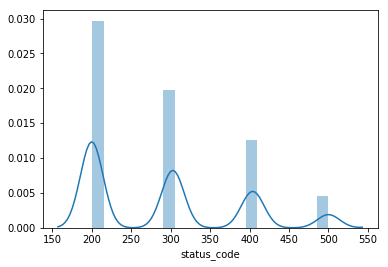

In [72]:
sns.distplot(combined_dataframe['status_code'])

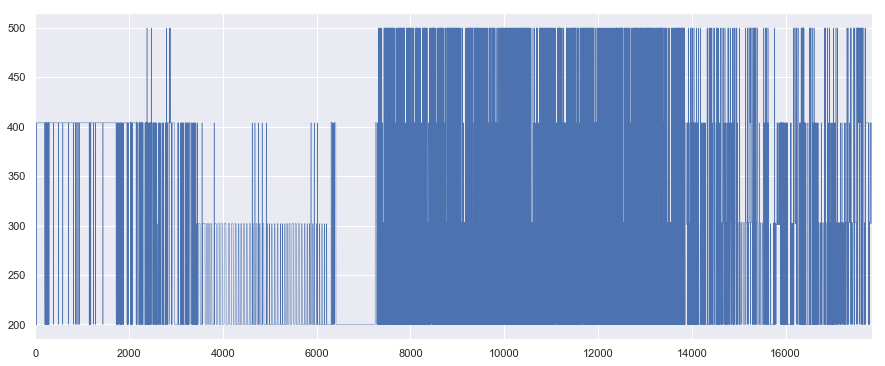

In [73]:
sns.set(rc={'figure.figsize':(15, 6)})
combined_dataframe['status_code'].plot(linewidth=0.5);

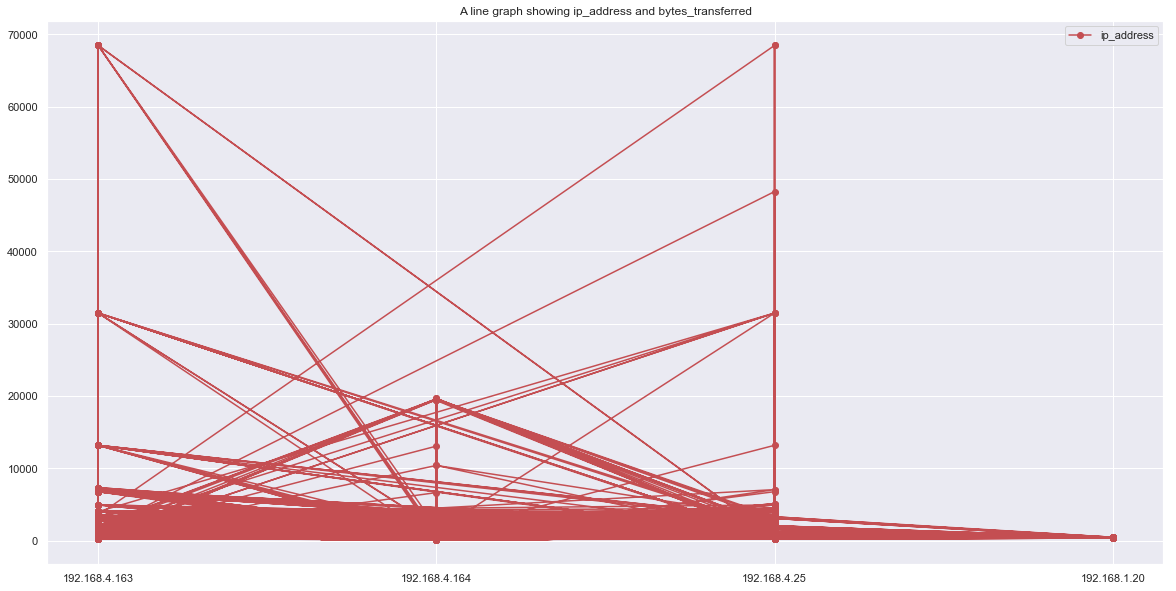

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

def printdata(combined_dataframe):
    print(combined_dataframe)
    
y=combined_dataframe['ip_address'].values
p=combined_dataframe['bytes_transferred'].values 
def selecteddata(col1,col2):
    print(col1)
    print(col2)

plt.plot(y,p,'r-o',label='ip_address')
plt.title("A line graph showing ip_address and bytes_transferred")
plt.legend()
plt.show()

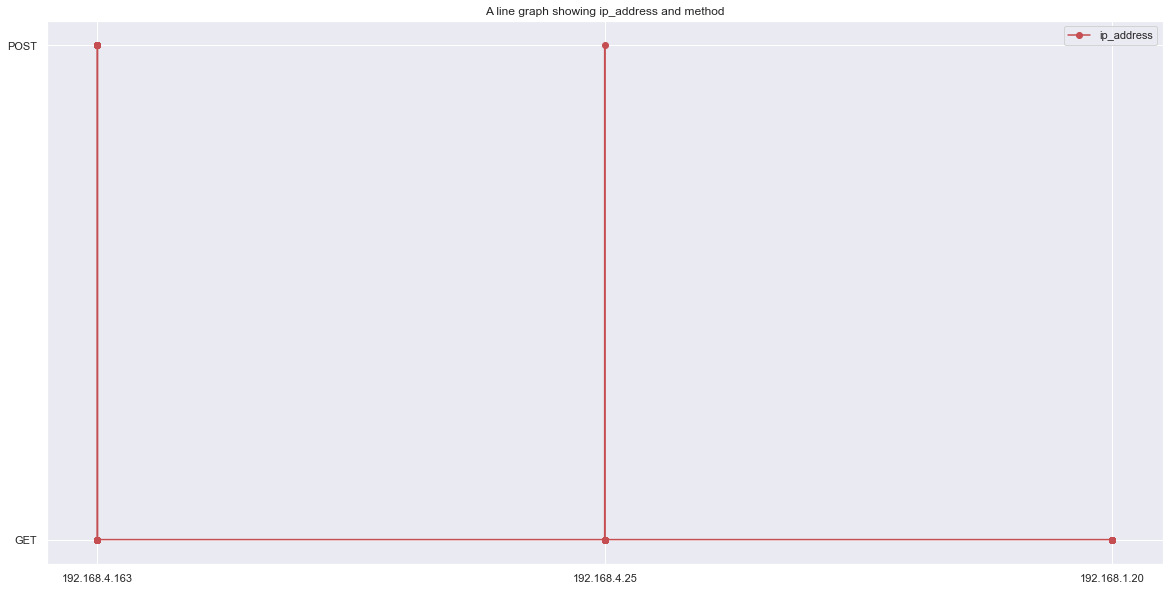

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

def printdata(combined_dataframe):
    print(combined_dataframe)
    
y=combined_dataframe['ip_address'].values
p=combined_dataframe['method'].values 
def selecteddata(col1,col2):
    print(col1)
    print(col2)

plt.plot(y,p,'r-o',label='ip_address')
plt.title("A line graph showing ip_address and method")
plt.legend()
plt.show()

# modelling

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold


print('status_code with 200', round(combined_dataframe['status_code'].value_counts()[200]/len(combined_dataframe) * 100,2), '% of the dataset')
print('status_code with 400', round(combined_dataframe['status_code'].value_counts()[400]/len(combined_dataframe) * 100,2), '% of the dataset')

X = combined_dataframe.drop('status_code', axis=1)
y = combined_dataframe['status_code']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No status_code 44.51 % of the dataset
status_code 0.06 % of the dataset


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train: [ 3423  3427  3433 ... 17846 17847 17848] Test: [    0     1     2 ...  3998  4855 13221]
Train: [    0     1     2 ... 17846 17847 17848] Test: [3423 3427 3433 ... 8529 8775 9716]
Train: [    0     1     2 ... 17846 17847 17848] Test: [ 6862  6882  6889 ... 11781 11795 11878]
Train: [    0     1     2 ... 17846 17847 17848] Test: [ 9827 10415 10420 ... 14573 14579 14654]
Train: [    0     1     2 ... 14573 14579 14654] Test: [11744 13685 14038 ... 17846 17847 17848]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[4.45035709e-01 7.00182047e-05 5.32138356e-03 6.25962750e-02
 2.29029548e-01 7.00182047e-05 6.30163843e-04 2.80072819e-04
 1.87648789e-01 7.00182047e-04 6.86178406e-02]
[4.45192038e-01 5.32660499e-03 6.25175217e-02 2.29044015e-01
 5.60695262e-04 2.80347631e-04 1.87832913e-01 5.60695262e-04
 6.86851696e-02]


In [128]:
combined_dataframe = combined_dataframe.sample(frac=1)
combined_dataframe
s200_df = combined_dataframe.loc[combined_dataframe['status_code'] == 200]
s400_df = combined_dataframe.loc[combined_dataframe['status_code'] == 400][:193]

normal_distributed_df = pd.concat([s200_df, s400_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,ip_address,remote_log_name,authenticated_user_name,timestamp,method,requested_url,protocol,status_code,bytes_transferred,referrer_url,user_agent,category1,type2,category2,type3,category3
6668,192.168.4.164,NaN,NaN,22/Dec/2016:15:21:18 +0300,GET,/DVWA/vulnerabilities/view_help.php?id=exec&se...,HTTP/1.1,200,1250.0,http://192.168.4.161/DVWA/vulnerabilities/exec/,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,1,0,0,0,0
13608,192.168.4.25,NaN,NaN,22/Dec/2016:16:33:13 +0300,POST,/index.php/component/search/,HTTP/1.1,200,3056.0,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1,0,0,0,0
14327,192.168.4.163,NaN,NaN,22/Dec/2016:22:35:54 +0300,GET,/index.php/component/users/?task=z6o9j%27z6o9j,HTTP/1.1,200,2761.0,http://192.168.4.161/,w3af.org,1,0,0,0,0
8299,192.168.4.25,NaN,NaN,22/Dec/2016:16:19:04 +0300,POST,/index.php,HTTP/1.1,200,1835.0,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1,0,0,0,0
16711,192.168.4.163,NaN,admin,22/Dec/2016:23:42:19 +0300,POST,/index.php/component/users/?task=remind.remind,HTTP/1.1,200,237.0,http://192.168.4.161/,w3af.org,1,0,0,0,0


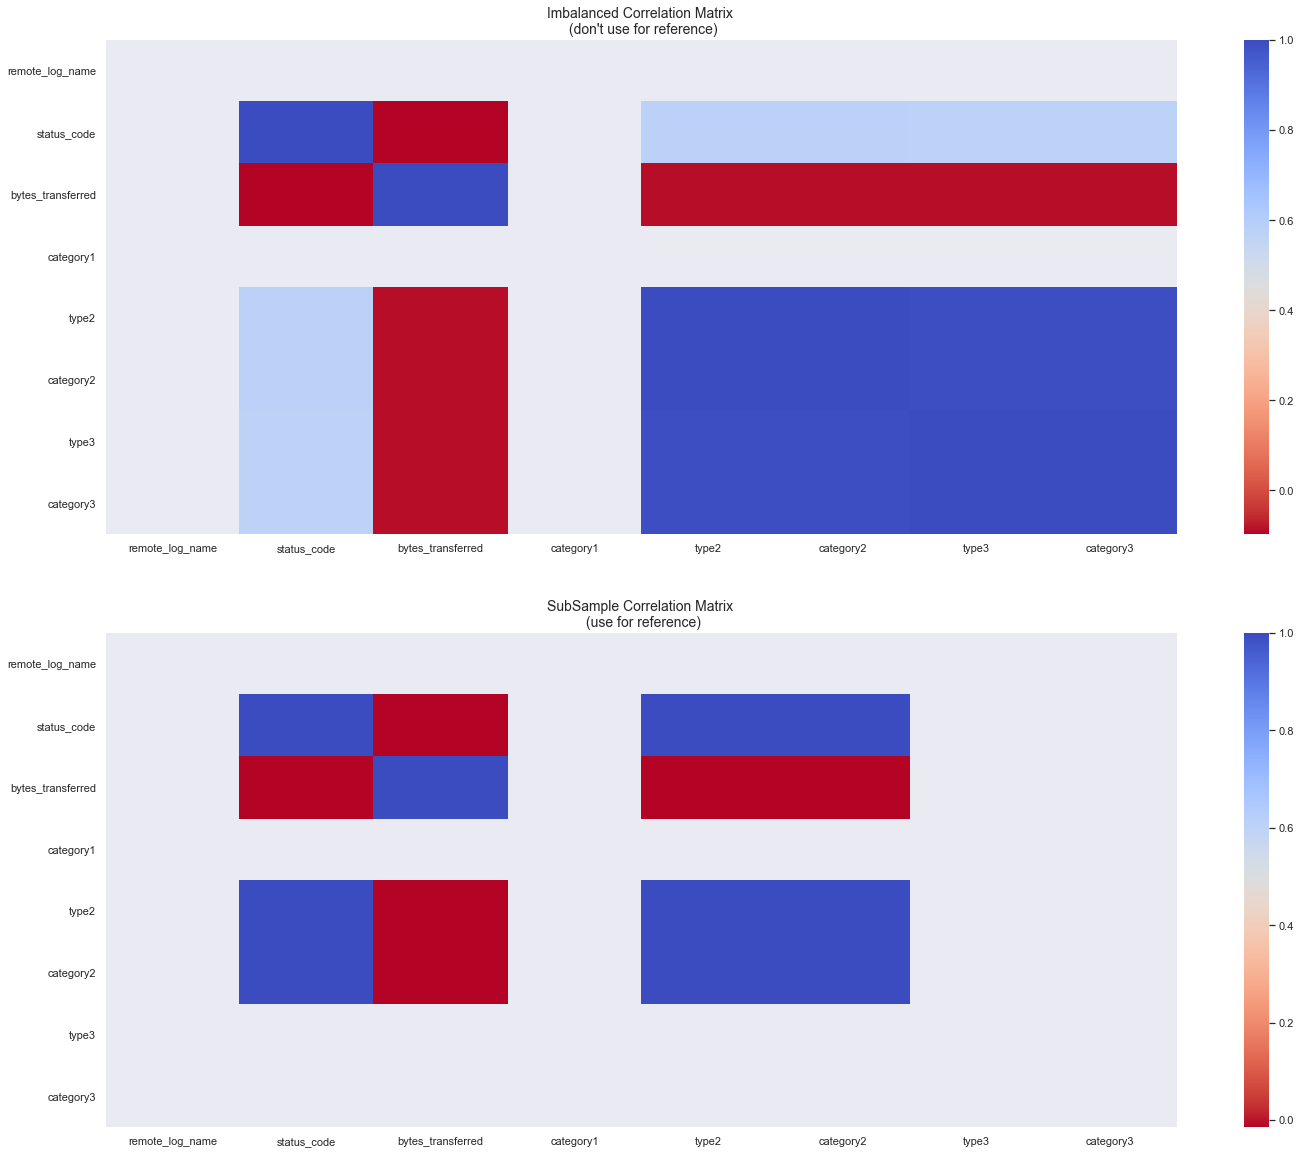

In [136]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = combined_dataframe.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()